# F. Analyse sentiment by sentence
## Import necessary libraries

In [1]:
import torch

# Verifica si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')


# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

C:\Users\luisl\AppData\Local\Temp\ipykernel_22252\269888456.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [4]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [5]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

## Load and process input data

Check the texts which is filtered by keyword as well

In [6]:
import pickle
import os

# Rutas de los archivos
ruta_original = 'C:/Users/Luis/Desktop/personal/tfm_ia3_nodata/data/preprocessed/'
ruta_nueva = 'C:/Users/luisl/OneDrive/Escritorio/TFM_IA3/tfm_ia3_nodata/data/preprocessed/'
archivos = ['text_no_split.pickle', 'text_keyword.pickle']

# Intentar cargar los archivos
text_no_split = None
text_keyword = None

for archivo in archivos:
    try:
        # Intenta abrir el archivo en la ruta original
        with open(os.path.join(ruta_original, archivo), 'rb') as file:
            if archivo == 'text_no_split.pickle':
                text_no_split = pickle.load(file)
            elif archivo == 'text_keyword.pickle':
                text_keyword = pickle.load(file)
        print(f"Archivo {archivo} encontrado en la ruta original.")
    except FileNotFoundError:
        try:
            # Si no se encuentra en la ruta original, intenta en la nueva
            with open(os.path.join(ruta_nueva, archivo), 'rb') as file:
                if archivo == 'text_no_split.pickle':
                    text_no_split = pickle.load(file)
                elif archivo == 'text_keyword.pickle':
                    text_keyword = pickle.load(file)
            print(f"Archivo {archivo} encontrado en la nueva ruta.")
        except FileNotFoundError:
            print(f"Archivo {archivo} no encontrado en ninguna de las rutas.")

# Usar las variables text_no_split y text_keyword según sea necesario.


Archivo text_no_split.pickle encontrado en la nueva ruta.
Archivo text_keyword.pickle encontrado en la nueva ruta.


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


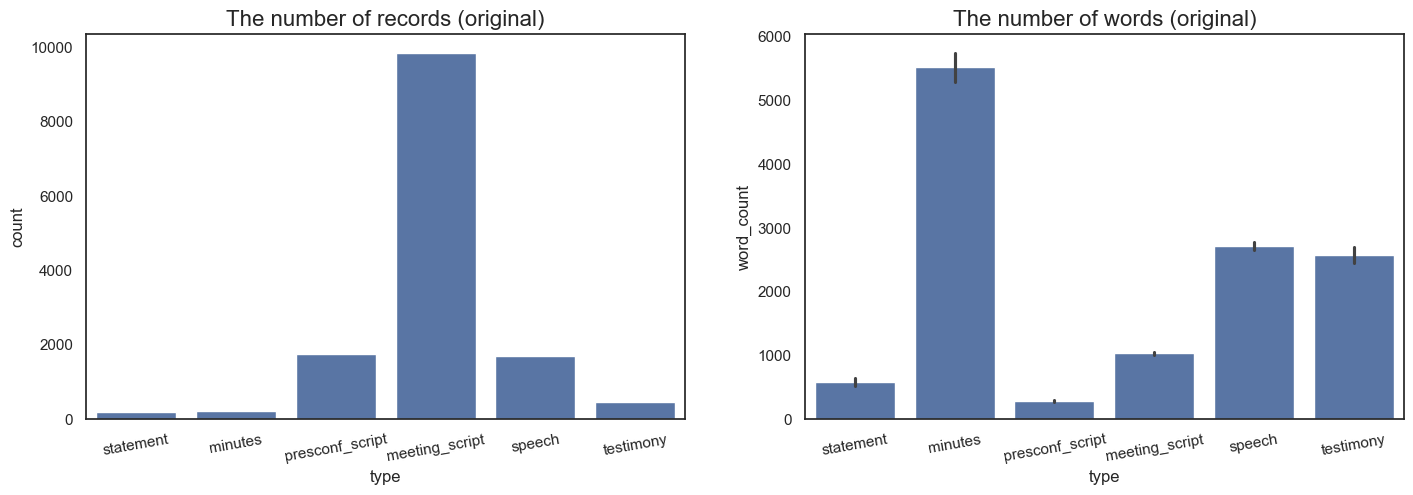

In [7]:
# Check the number of records per document type
def plot_num_rec_word(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
    sns.countplot(x='type', data=df, ax=ax1)
    ax1.set_title('The number of records (original)', fontsize=16)
    ax1.tick_params('x', labelrotation=10)
    sns.barplot(data=df, x='type', y='word_count', ax=ax2)
    ax2.set_title('The number of words (original)', fontsize=16)
    ax2.tick_params('x', labelrotation=10)

# All texts
plot_num_rec_word(text_no_split)
text_no_split.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,403,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,432,1,5.50,1997-05-20,0,5.50,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,400,-1,5.25,1998-10-15,-1,5.00,For immediate releaseThe Federal Open Market C...


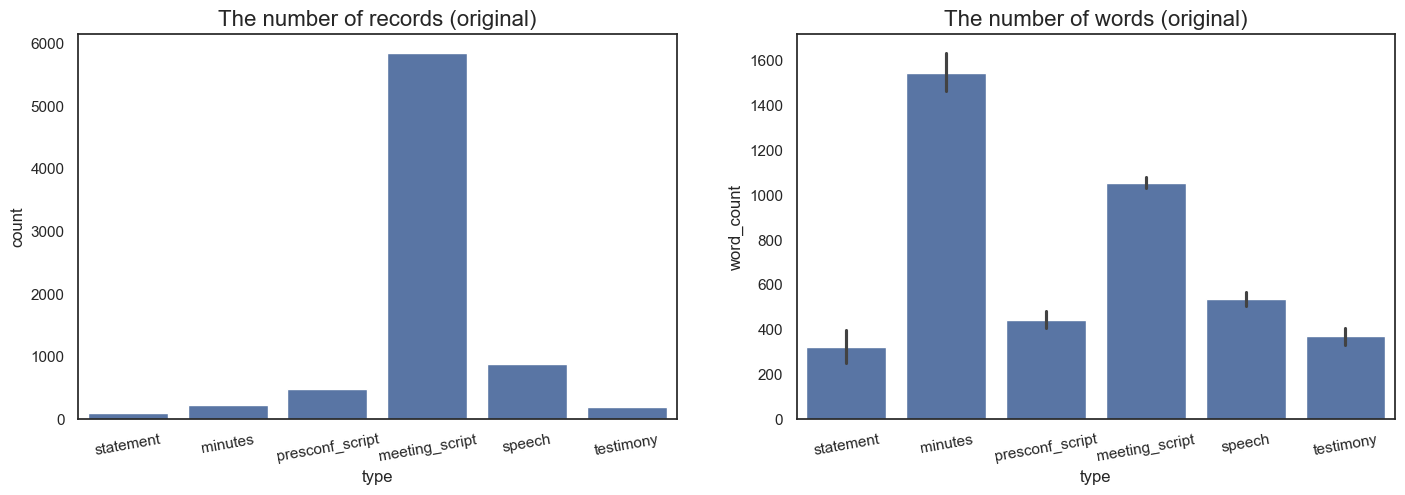

In [8]:
# Filtered by keywords
plot_num_rec_word(text_keyword)
text_keyword.head()

In [9]:
# # Drop meeting script data
# text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
# text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
# text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

### Select text dataframe
Here, use all the texts but keywords filtere one would give better performance - to be checked.

(4339, 11)


  0%|          | 0/9852 [00:00<?, ?it/s]

(4597, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


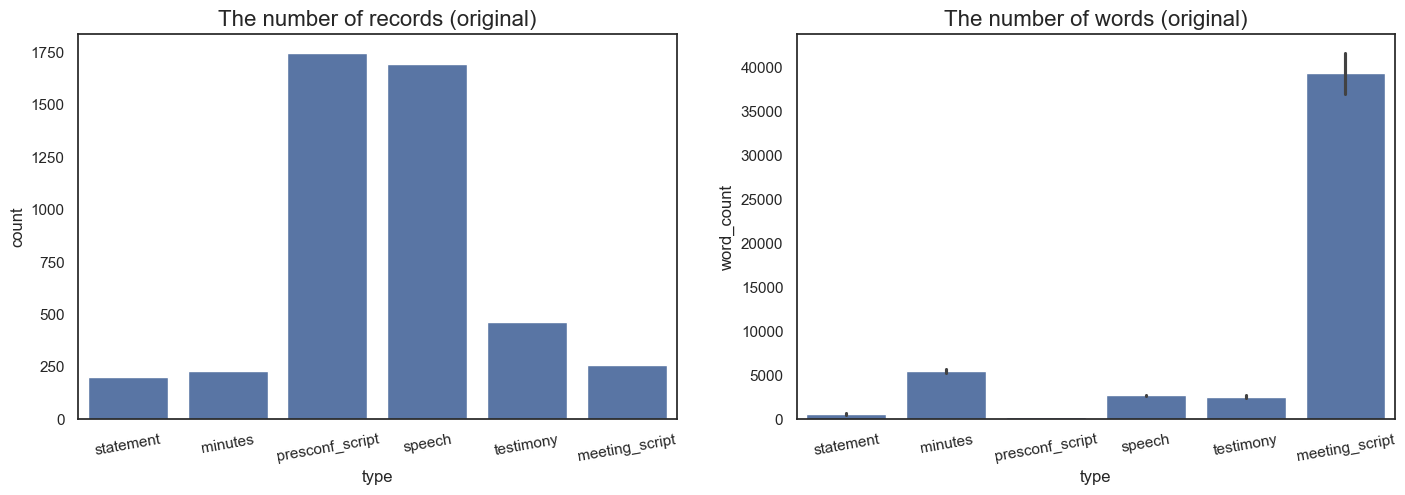

In [10]:
def combine_meeting_script(df):
    new_df = df.loc[df['type'] != 'meeting_script']
    print(new_df.shape)
    meeting_script_df = df.loc[df['type'] == 'meeting_script'].reset_index(drop=True)
    data_list = []
    for i, row in tqdm(meeting_script_df.iterrows(), total=meeting_script_df.shape[0]):
        if i == 0:
            prev_row = row
            continue
        if prev_row['date'].strftime('%Y-%m-%d') == row['date'].strftime('%Y-%m-%d'):
            prev_row['text'] = prev_row['text'] + row['text']
        else:
            prev_row['speaker'] = ""
            prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
            data_list.append(list(prev_row))
            prev_row = row

    prev_row['speaker'] = ""
    prev_row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', prev_row['text']))
    data_list.append(list(prev_row))
    new_meeting_script_df = pd.DataFrame(data_list, columns=df.columns)
    new_df = pd.concat([new_df, new_meeting_script_df], axis=0)
    print(new_df.shape)
    return new_df

train_df = combine_meeting_script(text_no_split)
plot_num_rec_word(train_df)
train_df.head()

In [11]:
train_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [12]:
# Calcular el número total de filas en el DataFrame
num_total_filas = train_df.shape[0]

print("Número total de filas en el DataFrame:", num_total_filas)

Número total de filas en el DataFrame: 4597


In [13]:
# Supongamos que tienes un DataFrame llamado df y una variable específica llamada 'variable_especifica'
variable_especifica = 'next_decision'

# Contar el número de filas con valores NaN en la variable especificada
num_filas_nan = train_df[variable_especifica].isnull().sum()

print("Número de filas con NaN en la variable '{}': {}".format(variable_especifica, num_filas_nan))


Número de filas con NaN en la variable 'next_decision': 31


In [14]:
# Filtrar el DataFrame para seleccionar solo las filas con valores NaN en la variable especificada
filas_nan = train_df[train_df[variable_especifica].isnull()]

# Obtener los valores de la columna "date" correspondientes a las filas con valores NaN
fechas_nan = filas_nan['date']

print("Valores de 'date' correspondientes a filas con NaN en la variable '{}':".format(variable_especifica))
print(fechas_nan)

Valores de 'date' correspondientes a filas con NaN en la variable 'next_decision':
201    2023-12-13
2151   2023-12-13
2152   2023-12-13
2153   2023-12-13
2154   2023-12-13
2155   2023-12-13
2156   2023-12-13
2157   2023-12-13
2158   2023-12-13
2159   2023-12-13
2160   2023-12-13
2161   2023-12-13
2162   2023-12-13
2163   2023-12-13
2164   2023-12-13
2165   2023-12-13
2166   2023-12-13
2167   2023-12-13
2168   2023-12-13
2169   2023-12-13
2170   2023-12-13
2171   2023-12-13
2172   2023-12-13
2173   2023-12-13
2174   2023-12-13
2175   2023-12-13
2176   2023-12-13
2177   2023-12-13
2178   2023-12-13
2179   2023-12-13
2180   2023-12-13
Name: date, dtype: datetime64[ns]


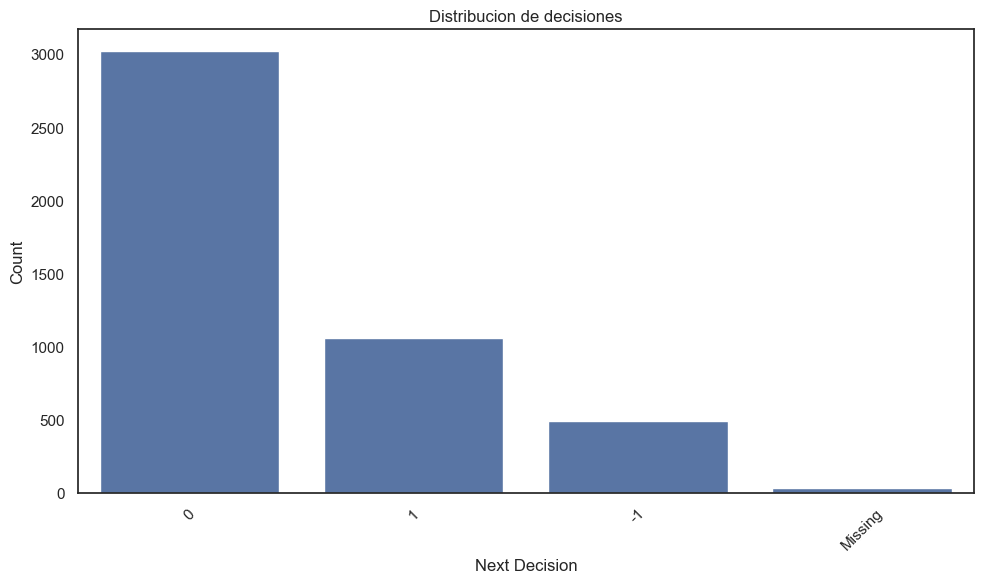

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
# Crear el gráfico de conteo
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='next_decision')

# Añadir etiquetas y título
plt.xlabel('Next Decision')
plt.ylabel('Count')
plt.title('Distribucion de decisiones')

# Mostrar el gráfico
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mayor claridad
plt.tight_layout()  # Ajustar el diseño para evitar solapamientos
plt.show()

c:\Users\luisl\anaconda3\envs\tfm_modelado\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


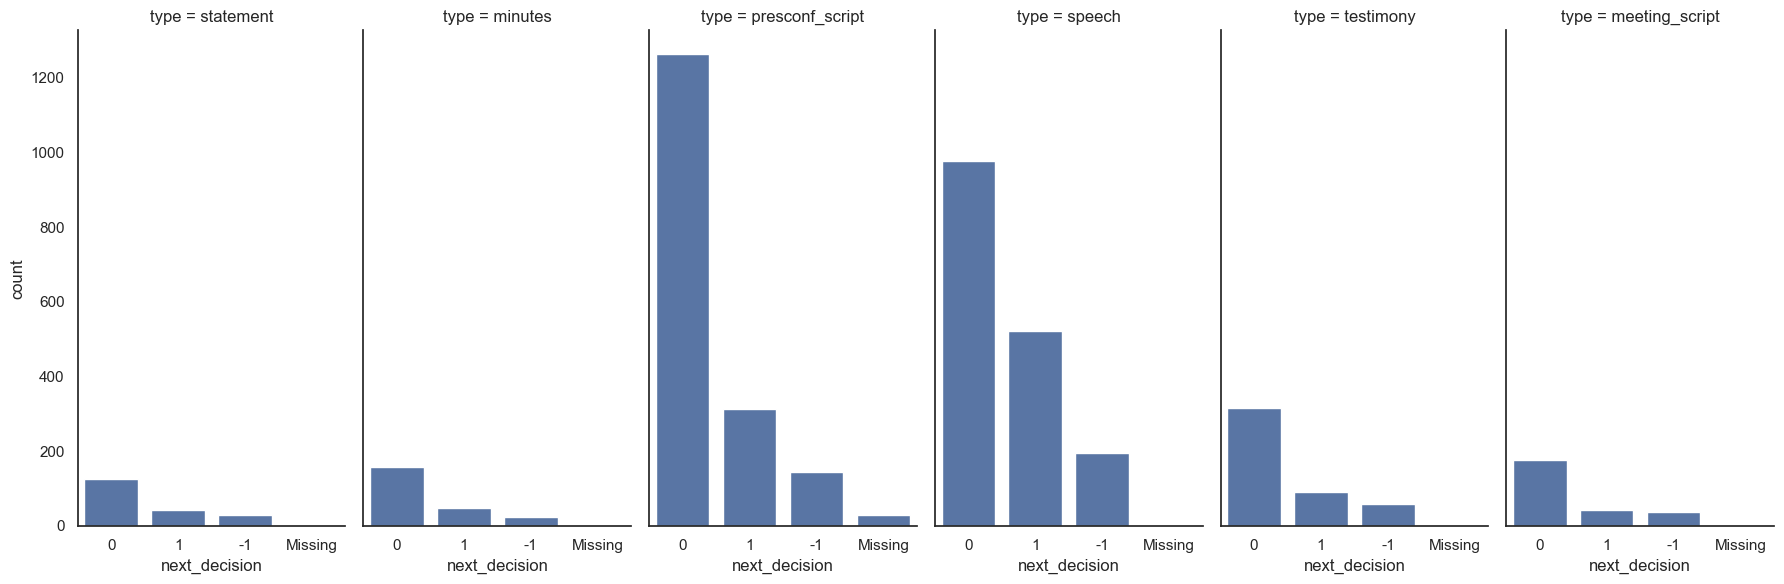

In [16]:
# Check balance of Rate Decision
train_df['next_decision'] = train_df['next_decision'].fillna('Missing')
g = sns.FacetGrid(train_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


C:\Users\luisl\AppData\Local\Temp\ipykernel_22252\4191536359.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
C:\Users\luisl\AppData\Local\Temp\ipykernel_22252\4191536359.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

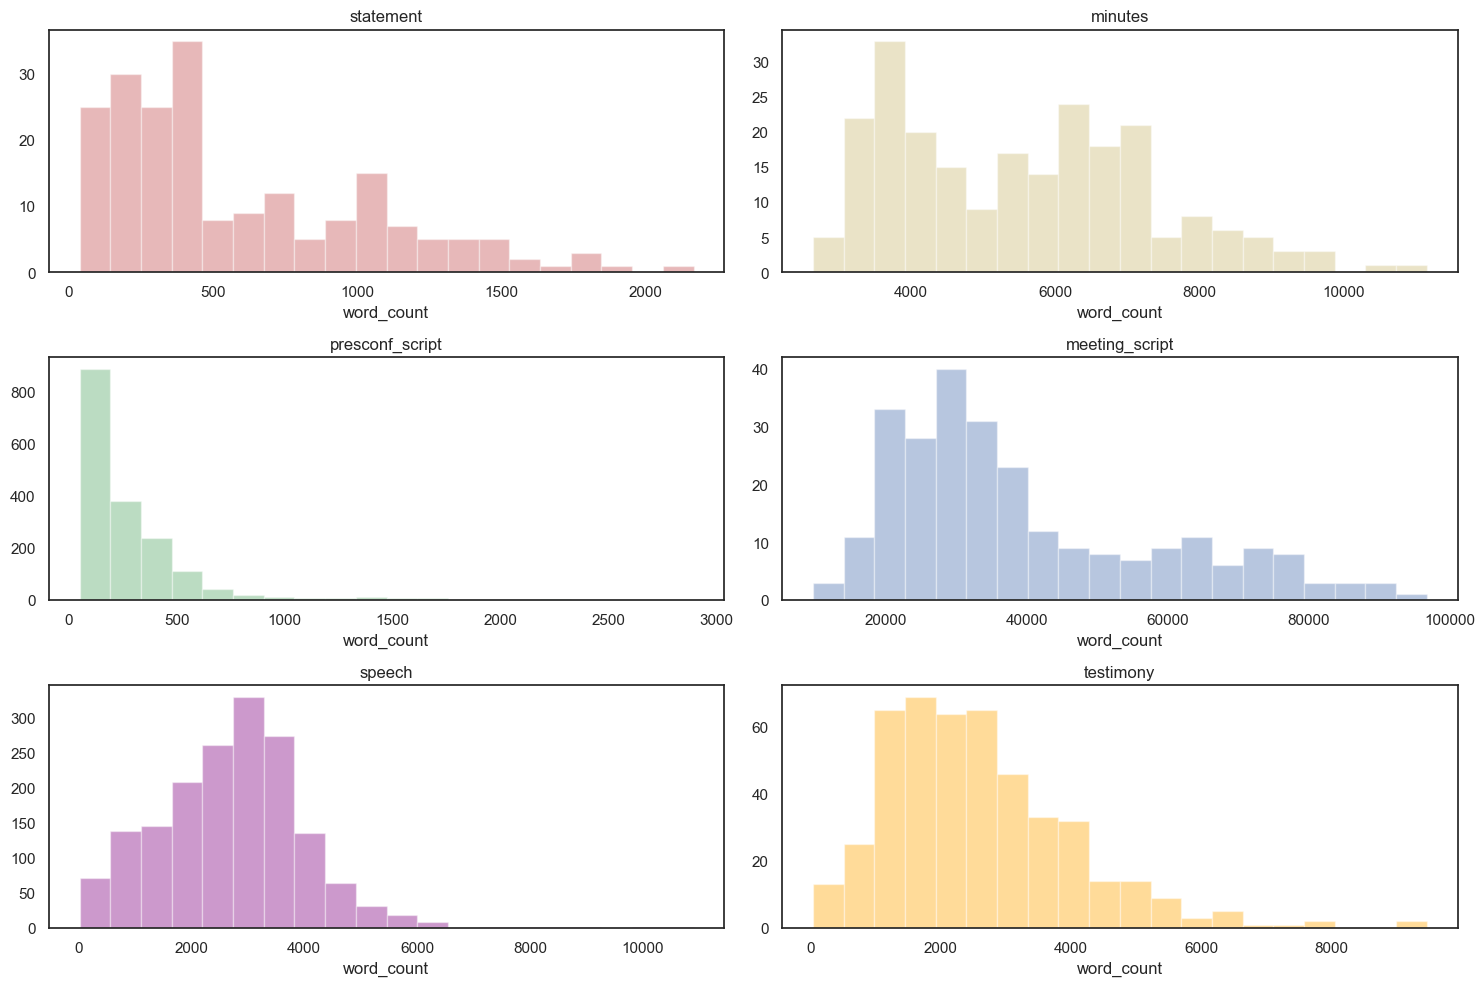

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
253,meeting_script,2014-04-30,FOMC Meeting Transcript,,78299,0,0.0,2014-06-18,0,0.0,"Good morning, everybody. Unfortunately, this i..."
254,meeting_script,2014-06-18,FOMC Meeting Transcript,,87191,0,0.0,2014-07-30,0,0.0,I'd like to begin by welcoming three people to...
255,meeting_script,2014-07-30,FOMC Meeting Transcript,,89115,0,0.0,2014-09-17,0,0.0,"Good morning, everybody. I would like to begin..."
256,meeting_script,2014-09-17,FOMC Meeting Transcript,,61267,0,0.0,2014-10-29,1,0.0,"Good morning, everybody.Our first two items th..."
257,meeting_script,2014-10-29,FOMC Meeting Transcript,,72330,1,0.0,2014-12-17,0,0.0,I'd like to call this meeting to order. Before...


In [17]:
# Check distribution
def plot_distribution(df, kde):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,10))
    doc_type = 'statement'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=kde, color='r')
    ax1.set_title(doc_type)
    doc_type = 'minutes'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=kde, color='y')
    ax2.set_title(doc_type)
    doc_type = 'presconf_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=kde, color='g')
    ax3.set_title(doc_type)
    doc_type = 'meeting_script'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=kde, color='b')
    ax4.set_title(doc_type)
    doc_type = 'speech'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=kde, color='purple')
    ax5.set_title(doc_type)
    doc_type = 'testimony'
    sns.distplot(df.loc[df['type'] == doc_type]['word_count'], bins=20, ax=ax6, kde=kde, color='orange')
    ax6.set_title(doc_type)

    fig.tight_layout(pad=1.0)
    plt.show()

plot_distribution(train_df, False)
train_df.tail()


## Load a trained model

In [18]:

train_sent_df = train_df[train_df['type'] != 'meeting_script']

In [19]:
train_sent_df.head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."


In [20]:
train_sent_df.shape

(4339, 11)

In [21]:
# Supongamos que quieres contar los NaN en la columna 'next_decision' de train_sent_df
nans_count = train_sent_df['next_decision'].isna().sum()

print(f"Número de valores NaN en la columna 'next_decision': {nans_count}")


Número de valores NaN en la columna 'next_decision': 0


In [22]:
train_sent_df = train_sent_df.dropna(subset=['next_decision'])
train_sent_df.shape

(4339, 11)

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

## Resumir los textos mediante modelado ##

In [24]:
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration

# Let's load the model and the tokenizer 
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Check GPU availability (assuming PyTorch)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device) # If you want to use the Tensorflow model 



Using device: cuda


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at human-centered-summarization/financial-summarization-pegasus and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
for idx, row in tqdm(train_sent_df.iterrows(), total=len(train_sent_df)):
  # Access text from dataframe
  text_to_summarize = row["text"]

  try:
    # Tokenize the text (without batching, truncation optional)
    input_ids = tokenizer(text_to_summarize, return_tensors="pt", truncation=True).input_ids.to(device)

    # Generate summary (assuming single output)
    output = model.generate(
        input_ids, 
        max_length=32, 
        num_beams=5, 
        early_stopping=True
    )

    # Decode the summary (handle potential multiple outputs)
    summary = tokenizer.decode(output[0], skip_special_tokens=True)  # Access first output

    # Update the dataframe with the summary
    train_sent_df.loc[idx, 'summary'] = summary

  except RuntimeError as e:
    print(f"Error during processing text '{text_to_summarize}': {e}")
    # Consider adding a placeholder for failed summaries (optional)
    # train_sent_df.loc[idx, 'summary'] = "Error: Summarization failed"

# Update progress bar after loop
tqdm.write("Summarization completed! Summaries added to 'summary' column.")

  0%|          | 0/4339 [00:00<?, ?it/s]

Summarization completed! Summaries added to 'summary' column.


In [26]:
train_sent_df['summary'][0]

'Decision to increase slightly the degree of pressure on reserve positions.'

In [27]:
X = train_sent_df['summary'].to_list()


In [28]:
import pandas as pd

# Porcentaje deseado de las filas (e.g., 10%)
porcentaje = 100

# Calcula el número de filas a seleccionar basado en el porcentaje
num_filas = int(len(train_sent_df) * (porcentaje / 100))

# Selecciona aleatoriamente el porcentaje deseado de filas del DataFrame
submuestra_df = train_sent_df.sample(n=num_filas)

submuestra_df = submuestra_df.dropna(subset=['next_decision'])

# Convierte la columna deseada a una lista
X_submuestra = submuestra_df['summary'].to_list()




In [29]:
nan_count = submuestra_df['next_decision'].isnull().sum()
nan_count

0

twitter-roberta-base-sentiment Model¶


In [31]:
import torch
import numpy as np
import scipy.special
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_roberta = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_roberta.to(device)

tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
labels = ['negative', 'neutral', 'positive']

# Asumiendo que X_submuestra es tu lista de textos a analizar
preds_roberta = []
preds_proba_roberta = []

for x in tqdm(X_submuestra, desc="Procesando predicciones"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        # Obtener las logits del modelo
        logits = model_roberta(**input_sequence).logits
        # Aplicar softmax en la GPU
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    
    sentimiento_general = labels[np.argmax(scores)]
    probabilidad_general = np.max(scores)
    
    preds_roberta.append(sentimiento_general)
    preds_proba_roberta.append(probabilidad_general)


Procesando predicciones: 100%|██████████| 4339/4339 [01:14<00:00, 58.24it/s]


In [32]:
submuestra_df['predicted_roberta'] = preds_roberta; submuestra_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta
13828,testimony,2000-04-11,Hedge funds and over-the-counter derivatives,"Patrick M. Parkinson, Associate Director, Divi...",1140,<NA>,NaN,2000-05-16,1,6.50,I am pleased to be here today to discuss effor...,Board supports President's Working Group recom...,neutral
1448,presconf_script,2020-09-16,FOMC Press Conference Transcript,STEVE LIESMAN. Thank you. MICHELLE SMITH. Than...,460,0,0.00,2020-11-05,0,0.00,"Hi, Chair Powell. Thanks very much for taking ...",Here is the full text of Powell's remarks afte...,neutral
12515,speech,2004-04-23,Global Imbalances,"Vice Chairman Roger W. Ferguson, Jr.",2219,<NA>,NaN,2004-05-04,0,1.00,I am pleased to participate in a discussion wi...,I am writing to you on the subject of current ...,neutral
17,statement,1999-10-05,FOMC Statement,Alan Greenspan,1040,0,5.25,1999-11-16,1,5.50,For immediate releaseThe Federal Open Market C...,Decision was held as expected.,neutral
1634,presconf_script,2021-07-28,FOMC Press Conference Transcript,MICHELLE SMITH,369,0,0.00,2021-09-22,0,0.00,Thank you. Let's go to Steve Liesman with CNBC...,Chairman Powell: We have some ground to cover ...,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13296,speech,2017-04-17,Monetary Policy Expectations and Surprises,Vice Chairman Stanley Fischer,2815,<NA>,NaN,2017-06-14,1,NaN,"Of course, not all surprises are equal. For on...",Central banks need to manage market expectations.,neutral
466,presconf_script,2011-06-22,FOMC Press Conference Transcript,NEIL IRWIN,70,0,0.00,2011-08-01,0,0.00,"Mr. Chairman, Neil Irwin with the Washington P...",Panel to discuss setting own 2 percent inflati...,neutral
12944,speech,2010-03-20,Preserving a Central Role for Community Banking,Ben Bernanke,3149,<NA>,NaN,2010-04-28,0,0.00,I'm glad once again to be able to meet with an...,Here is the text of Fed chair Janet Yellen's s...,neutral
13624,speech,2022-11-16,The Economic Outlook and a Word of Caution on ...,Governor Christopher J. Waller,2934,<NA>,NaN,2022-12-14,1,4.25,I will begin with some comments on the overall...,Here is the text of Federal Reserve chair Jero...,neutral


yiyanghkust/finbert-tone Model

In [34]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import pandas as pd
from tqdm.auto import tqdm

# Inicialización del modelo y tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone', num_labels=3)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finbert.to(device)

nlp = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Asumiendo que submuestra_df es tu DataFrame y tiene una columna 'text'
predicted_finbert_tone = []

for text in tqdm(submuestra_df['summary'], desc="Analizando sentimientos"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        result = nlp(text)[0]
    
    sentimiento_final = result['label'].lower()
    predicted_finbert_tone.append(sentimiento_final)

# Añadir los resultados al DataFrame
submuestra_df['predicted_finbertTone'] = predicted_finbert_tone


Analizando sentimientos:   0%|          | 0/4339 [00:00<?, ?it/s]

ProsusAI/finbert Model


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm.auto import tqdm
import numpy as np

# Inicialización del tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finbert.to(device)

preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}

for x in tqdm(X_submuestra, desc="Procesando predicciones FinBERT"):
    with torch.no_grad():
        # Tokenizar y mover el texto completo a la GPU
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs).to(device)
        logits = model_finbert(**input_sequence).logits
        scores = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        scores_dict = {
            label: score
            for label, score in zip(model_finbert.config.id2label.values(), scores)
        }
        sentimiento = max(scores_dict, key=scores_dict.get)
        probabilidad = max(scores_dict.values())
    
    preds.append(sentimiento)
    preds_proba.append(probabilidad)



Procesando predicciones FinBERT:   0%|          | 0/4339 [00:00<?, ?it/s]

In [36]:
submuestra_df['predicted_finbert'] =preds

hacer la columna sentiment en el dataset de entrenamiento teniendo en cuenta las agregaciones de key y cambiar de 1 a positive etc

In [37]:

y = submuestra_df['next_decision'].to_list()
y = [ 'neutral' if value == 0 else 'positive' if value == 1 else 'negative' for value in y ]


In [38]:
submuestra_df.tail()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,summary,predicted_roberta,predicted_finbertTone,predicted_finbert
13296,speech,2017-04-17,Monetary Policy Expectations and Surprises,Vice Chairman Stanley Fischer,2815,<NA>,NaN,2017-06-14,1,NaN,"Of course, not all surprises are equal. For on...",Central banks need to manage market expectations.,neutral,neutral,neutral
466,presconf_script,2011-06-22,FOMC Press Conference Transcript,NEIL IRWIN,70,0,0.0,2011-08-01,0,0.00,"Mr. Chairman, Neil Irwin with the Washington P...",Panel to discuss setting own 2 percent inflati...,neutral,neutral,neutral
12944,speech,2010-03-20,Preserving a Central Role for Community Banking,Ben Bernanke,3149,<NA>,NaN,2010-04-28,0,0.00,I'm glad once again to be able to meet with an...,Here is the text of Fed chair Janet Yellen's s...,neutral,neutral,neutral
13624,speech,2022-11-16,The Economic Outlook and a Word of Caution on ...,Governor Christopher J. Waller,2934,<NA>,NaN,2022-12-14,1,4.25,I will begin with some comments on the overall...,Here is the text of Federal Reserve chair Jero...,neutral,neutral,neutral
860,presconf_script,2014-06-18,FOMC Press Conference Transcript,MICHAEL MCKEE,116,0,0.0,2014-07-30,0,0.00,Michael McKee from Bloomberg Television and Ra...,Questions at Yellen's press conference about r...,neutral,neutral,neutral


In [39]:
submuestra_df['text'][0]

"Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated with a small increase in short-term money market interest rates. The decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion. Chairman Greenspan decided to announce this action immediately so as to avoid any misunderstanding of the Committee's purposes, given the fact that this is the first firming of reserve market conditions by the Committee since early 1989."

## Model evaluation

In [40]:
def evaluate_model_accuracy(model_name, y_pred):
    accuracy = accuracy_score(y, y_pred)
    print(f'Model: {model_name} - Accuracy-Score: {accuracy:.4f}')

In [41]:
evaluate_model_accuracy('ProsusAI/finbert', preds)
evaluate_model_accuracy('cardiffnlp/twitter-roberta-base-sentiment', preds_roberta)
evaluate_model_accuracy('yiyanghkust/finbert-tone', submuestra_df.predicted_finbertTone)

Model: ProsusAI/finbert - Accuracy-Score: 0.5510
Model: cardiffnlp/twitter-roberta-base-sentiment - Accuracy-Score: 0.5746
Model: yiyanghkust/finbert-tone - Accuracy-Score: 0.5580


In [42]:
print(classification_report(y,preds))
print(classification_report(y,preds_roberta))
print(classification_report(y,submuestra_df.predicted_finbertTone))

              precision    recall  f1-score   support

    negative       0.14      0.13      0.14       484
     neutral       0.66      0.77      0.71      2840
    positive       0.26      0.15      0.19      1015

    accuracy                           0.55      4339
   macro avg       0.35      0.35      0.35      4339
weighted avg       0.51      0.55      0.52      4339

              precision    recall  f1-score   support

    negative       0.13      0.07      0.09       484
     neutral       0.66      0.81      0.73      2840
    positive       0.28      0.16      0.20      1015

    accuracy                           0.57      4339
   macro avg       0.36      0.35      0.34      4339
weighted avg       0.51      0.57      0.53      4339

              precision    recall  f1-score   support

    negative       0.14      0.14      0.14       484
     neutral       0.66      0.78      0.72      2840
    positive       0.27      0.13      0.17      1015

    accuracy        

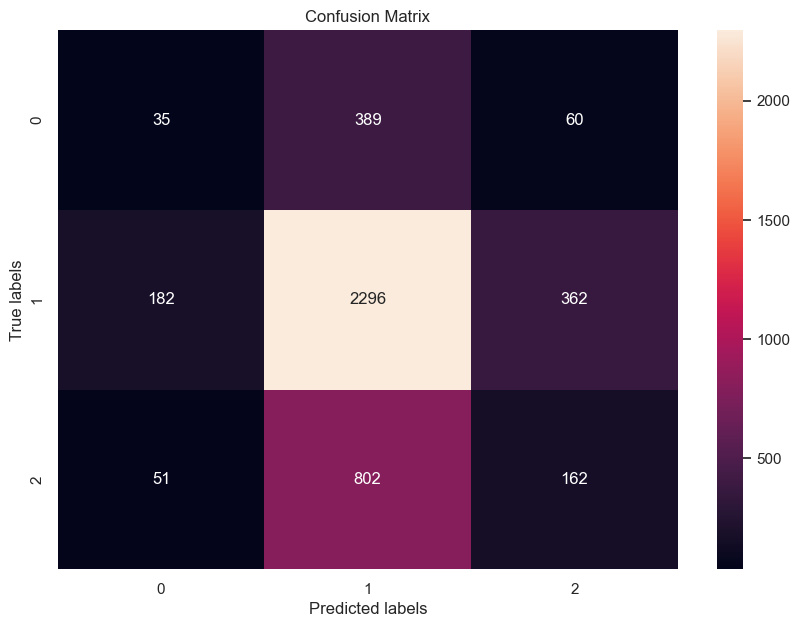

In [43]:
cm = confusion_matrix(y, preds_roberta)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

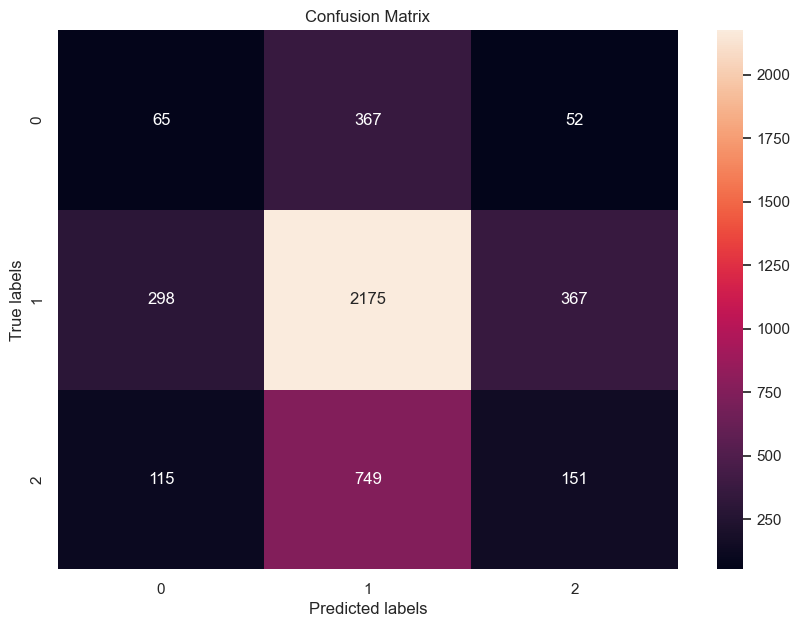

In [44]:
cm = confusion_matrix(y, preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

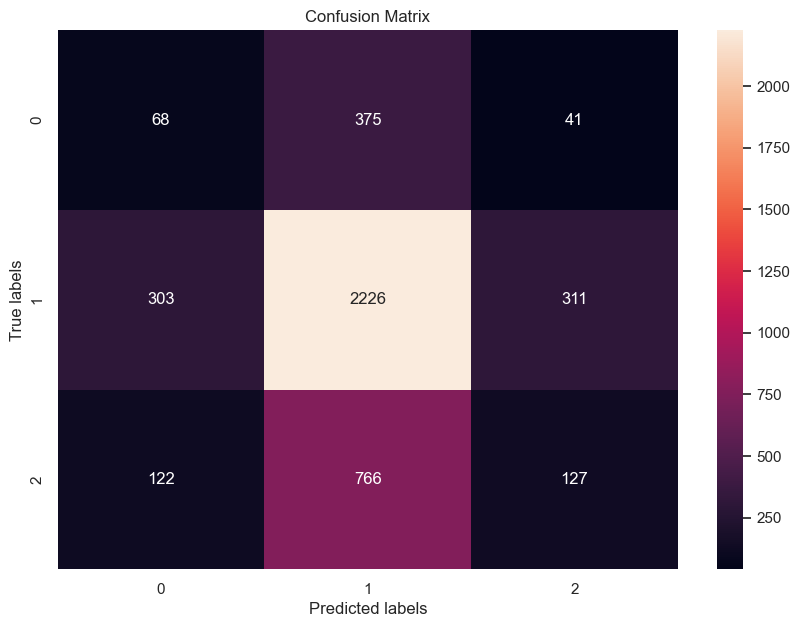

In [45]:
cm = confusion_matrix(y, submuestra_df.predicted_finbertTone)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()